In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')
pd.set_option('display.max_columns', None)

/Users/varnika/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/gw/xg9wcgln7x1f2k7qpz6vkm_c0000gn/T/ipykernel_49442/1522025319.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')


In [2]:
# rapid flow of snow down the slope - Avalanches

In [3]:
avalanche_ac_vars = [
    "vill_road_coverage",        # fraction of villages with all-weather roads
    "vill_rwh_coverage",         # fraction with rainwater-harvesting (some resilience to weather extremes)
    "vill_elec_no_ratio",        # fraction of villages with no electricity (inverse capacity)
    "vill_elec_mt_12_ratio",     # fraction with >12 hrs electricity
    "bc_per_10k_pop",            # bank correspondents per 10k population
    "branch_per_10k_pop",        # bank branches per 10k population
    "shg_per_1000_hh",           # self-help groups indicating social capital
    "loan_per_hh",               # average credit/loan per household
    "jobcard_issued_ratio",      # fraction of HHs with MGNREGA jobcards
    "active_jobcard_ratio",      # fraction actively used
    "pmuy_ratio",                # coverage of LPG (clean fuel)
    "hh_non_farm_ratio",         # livelihood diversification
    "irrigation_ratio"           # fraction of net irrigated area (if relevant to avalanche context)
]


In [4]:
import pandas as pd

# ID columns to keep track of block/district
id_cols = ["state_code", "district_code", "block_code", "FID_Key"]

# Combine them with your chosen avalanche AC variables
avalanche_ac_cols = id_cols + avalanche_ac_vars

# Subset from your master DataFrame (assuming it's df)
avalanche_ac_df = df[avalanche_ac_cols].copy()

# Check for missing data
print(avalanche_ac_df.isna().sum())


state_code               0
district_code            0
block_code               0
FID_Key                  0
vill_road_coverage       0
vill_rwh_coverage        0
vill_elec_no_ratio       0
vill_elec_mt_12_ratio    0
bc_per_10k_pop           0
branch_per_10k_pop       0
shg_per_1000_hh          0
loan_per_hh              0
jobcard_issued_ratio     0
active_jobcard_ratio     0
pmuy_ratio               0
hh_non_farm_ratio        0
irrigation_ratio         0
dtype: int64


In [5]:
from sklearn.preprocessing import RobustScaler

Rscaler = RobustScaler()

# Only scale your AC variables
features_only = avalanche_ac_df[avalanche_ac_vars].astype(float).values
features_scaled = Rscaler.fit_transform(features_only)

# Create a scaled DataFrame
ac_scaled = pd.DataFrame(features_scaled,
                         columns=avalanche_ac_vars,
                         index=avalanche_ac_df.index)

# Attach these scaled columns back to avalanche_ac_df (or keep them separate)
for col in avalanche_ac_vars:
    avalanche_ac_df[col + "_scaled"] = ac_scaled[col]


In [6]:
from sklearn.decomposition import PCA
import numpy as np

# Gather only scaled columns
ac_pca_vars = [c for c in avalanche_ac_df.columns if c.endswith("_scaled")]
X_ac = avalanche_ac_df[ac_pca_vars].astype(float)

pca = PCA()
pca.fit(X_ac)

# Summarize variance
pcaSummary_ava_ac = pd.DataFrame({
    '% variance': pca.explained_variance_ratio_,
    'Cumulative %': np.cumsum(pca.explained_variance_ratio_)
})
print(pcaSummary_ava_ac.round(3))


    % variance  Cumulative %
0        0.705         0.705
1        0.109         0.814
2        0.051         0.865
3        0.045         0.910
4        0.027         0.936
5        0.017         0.953
6        0.013         0.967
7        0.011         0.977
8        0.010         0.987
9        0.006         0.993
10       0.004         0.997
11       0.003         1.000
12       0.000         1.000


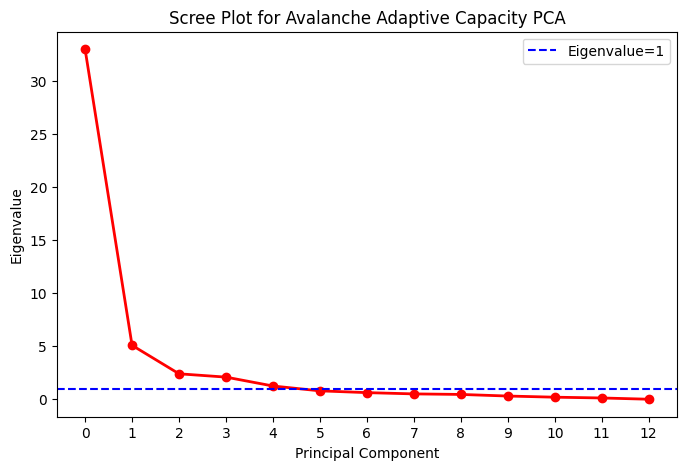

In [7]:
import matplotlib.pyplot as plt

eigenvalues = pca.explained_variance_
xvals = np.arange(len(eigenvalues))

plt.figure(figsize=(8,5))
plt.plot(xvals, eigenvalues, 'ro-', linewidth=2)
plt.title("Scree Plot for Avalanche Adaptive Capacity PCA")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.axhline(y=1, color='b', linestyle='--', label="Eigenvalue=1")
plt.xticks(xvals)
plt.legend()
plt.show()


In [8]:
n_components = 4
pca_n = PCA(n_components=n_components)
X_ac_pca = pca_n.fit_transform(X_ac)

pca_weights = pcaSummary_ava_ac['% variance'][:n_components]

# Add PC columns to DataFrame
for i in range(n_components):
    avalanche_ac_df[f"AvalancheAC_PC{i+1}"] = X_ac_pca[:, i]

# Weighted sum => "Avalanche_AdaptiveCap_Index"
avalanche_ac_df["Avalanche_AdaptiveCap_Index"] = 0
for i in range(n_components):
    avalanche_ac_df["Avalanche_AdaptiveCap_Index"] += (
        pca_weights.iloc[i] * avalanche_ac_df[f"AvalancheAC_PC{i+1}"]
    )

print(avalanche_ac_df[["block_code", "Avalanche_AdaptiveCap_Index"]].head())
print(avalanche_ac_df["Avalanche_AdaptiveCap_Index"].describe())


   block_code  Avalanche_AdaptiveCap_Index
0        6498                    -0.067165
1        6492                    -0.996775
2        4689                     2.579089
3        4690                    -0.724012
4        4692                    -0.422838
count    5.815000e+03
mean     7.820247e-17
std      4.061794e+00
min     -1.645480e+00
25%     -8.111761e-01
50%     -5.105656e-01
75%     -2.679471e-02
max      1.963378e+02
Name: Avalanche_AdaptiveCap_Index, dtype: float64


In [9]:
loadings_ac = pd.DataFrame(
    pca_n.components_.T,
    index=ac_pca_vars,
    columns=[f"PC{i+1}" for i in range(n_components)]
)
print(loadings_ac)


                                   PC1       PC2       PC3       PC4
vill_road_coverage_scaled     0.010582 -0.171623 -0.076613 -0.012914
vill_rwh_coverage_scaled      0.003754 -0.089145 -0.040640 -0.014137
vill_elec_no_ratio_scaled    -0.012037  0.688419 -0.071056  0.035063
vill_elec_mt_12_ratio_scaled -0.012037  0.688419 -0.071056  0.035063
bc_per_10k_pop_scaled         0.454164  0.031694  0.652162  0.581777
branch_per_10k_pop_scaled     0.890231  0.005439 -0.330021 -0.293770
shg_per_1000_hh_scaled       -0.004628  0.031468  0.145549 -0.242455
loan_per_hh_scaled           -0.002708  0.002112  0.244016 -0.354254
jobcard_issued_ratio_scaled   0.001332  0.063128  0.449253 -0.457574
active_jobcard_ratio_scaled   0.006140  0.054213  0.357909 -0.393442
pmuy_ratio_scaled            -0.010646 -0.003294  0.115490  0.046409
hh_non_farm_ratio_scaled      0.023037 -0.056809 -0.154309  0.049241
irrigation_ratio_scaled      -0.009782 -0.050642 -0.018604  0.139212
